# RNBA-1252 November-December Experiment Postcode Pricing Selection

https://virginmediao2.atlassian.net/browse/RNBA-1252

## Steps 

0 - update the XGS PON / Nexfibre postcodes (which are to be excluded here)

1 - determine eligible postcodes and randomly allocate to treatment groups (then run some sense checks)

2 - upload the bundle prices 

3 - generate the corresponding files for Compax


# TODO 

group names should be UNinformative for deployment


WE WILL BE EXCLUDING 1) NON-OVERBUILD; and 2) NEXFIBRE -- make these changes when confirmed

In [54]:
import pandas as pd
import json
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from google.cloud import bigquery
from itertools import combinations
from datetime import datetime

In [55]:
import sys
sys.path.append('../src')

In [56]:
bq_client = bigquery.Client(
    project='prj-vo-aa-p-data-science-exp', 
    location='europe-west2')

# How much traffic will we have?

In [57]:
# assume 50% for now
pct_selection = 0.50  

# Table Refs / labelling

Keep these updated (including the Jira number)

In [58]:
dataset = "m7914180"

postcode_treatment_table = "rnba-1252-postcode-pricing-group-allocations"
bundle_price_table = "rnba-1252-bundle-prices"

print(f"Postcodes and treatment groups go in:\n{bq_client.project}.{dataset}.{postcode_treatment_table}\n")
print(f"Bundles prices for treatment groups go in:\n{bq_client.project}.{dataset}.{bundle_price_table}")

Postcodes and treatment groups go in:
prj-vo-aa-p-data-science-exp.m7914180.rnba-1252-postcode-pricing-group-allocations

Bundles prices for treatment groups go in:
prj-vo-aa-p-data-science-exp.m7914180.rnba-1252-bundle-prices


In [59]:
xgs_pon_table = "xgs_pon_postcodes"
print(f"XGS PON (aka Nexfibre) postcodes in:\n{bq_client.project}.{dataset}.{xgs_pon_table}")

XGS PON (aka Nexfibre) postcodes in:
prj-vo-aa-p-data-science-exp.m7914180.xgs_pon_postcodes


In [60]:
### For labelling

jira_code = "rnba-1252"


# Step 0 - Update the XGS-PON data (=Nexfibre)

This is in an Excel sheet sent out daily by Darren Martin. Need to update the BQ table manually.

In [61]:
from pyxlsb import open_workbook as open_xlsb

In [62]:
# need to manually update this file
path_to_file = "../data/nexfibre/Daily nexfibre tracker.xlsb"

df = []
wb = open_xlsb(path_to_file)
ws = wb.get_sheet('Post_Code_Roll_Up')
for row in ws.rows():
    df.append([item.v for item in row])  # retrieving the value

nexfibre_postcodes_to_exclude = (pd.DataFrame(df[1:], columns=df[0])  # first row is header, second row has (hidden) totals
                                    .iloc[:,0:8]  # multiple columns with the same names; leftmost ones are the ones we want
                                    .dropna(subset=['postal_town'])  # drop after we limit the columns -- new duplicate column names have appeared in the file
                                    .assign(

                                        # LS (="Live and Serviceable) and LW (="Live and serviceable (required Wayleave)") is basically what we can sell to in the short term
                                        LS_and_LW = lambda df: df.LS + df.LW
                                    )
                                    # we will *exclude* these postcodes
                                   .query("LS_and_LW > 0") 
                                    ) 

cols = ['CURRENT_POSTCODE',  'LS', 'LW', 'LS_and_LW']
nexfibre_postcodes_to_exclude = nexfibre_postcodes_to_exclude[cols].rename(columns={'CURRENT_POSTCODE': 'postcode'})
nexfibre_postcodes_to_exclude.shape

(9971, 4)

In [63]:
nexfibre_postcodes_to_exclude.sort_values('postcode').head()

postcode   LS   LW  LS_and_LW
3878  BD207AS  6.0  0.0        6.0
5519  BD207AT  1.0  1.0        2.0
3737  BD207AW  3.0  0.0        3.0
4972  BD207AX  1.0  0.0        1.0
1888  BD207ET  4.0  0.0        4.0

In [64]:
# # check I have got the right sort of thing for the XGS PON postcodes
# old_xgs_pon_list = bq_client.query("SELECT * FROM prj-vo-aa-p-data-science-exp.m7914180.xgs_pon_postcodes_17_april_go_live").to_dataframe()
# old_xgs_pon_list.shape  # 2941 cases

# # postcodes that were in an old list but are not in the new list should be nothing here -- find 333. Possible this is just the result of plan changes?
# discrepancies = [pcode for pcode in old_xgs_pon_list.postcode if pcode not in nexfibre_postcodes_to_exclude.postcode.values]
# len(discrepancies)

# should be lots here - 2608
# reverse_discrepancies = [pcode for pcode in old_xgs_pon_list.postcode if pcode in nexfibre_postcodes_to_exclude.postcode.values]
# len(reverse_discrepancies)

In [65]:
# upload the refreshed XGS PON / Nexfibre exclusions to BQ

job_config = bigquery.LoadJobConfig(schema=[
    bigquery.SchemaField("postcode", "STRING"),
    bigquery.SchemaField("LS", "float"),
    bigquery.SchemaField("LW", "float"),
    bigquery.SchemaField("LS_and_LW", "float"),
], write_disposition="WRITE_TRUNCATE") 

xgs_pon_table_id = f'{dataset}.{xgs_pon_table}'

job = bq_client.load_table_from_dataframe(
    nexfibre_postcodes_to_exclude, xgs_pon_table_id, job_config=job_config
)

print(f"Updated XGN PON postcodes in {bq_client.project}.{xgs_pon_table_id}")

Updated XGN PON postcodes in prj-vo-aa-p-data-science-exp.m7914180.xgs_pon_postcodes


# 1 - Assign postcodes to treatment groups

Currently: overbuild / non-overbuild areas each have a control and 21 variants, for a total of 4 groups.

We take a certain pct of traffic, to leave some from other experiment.


In [119]:
%%time

postcode_pricing_query_template = """

WITH 
xgs_pon AS (

    -- to be excluded
    SELECT
        postcode,
        UPPER(TRIM(REGEXP_REPLACE(postcode, ' ', ''))) AS postcode_no_spaces,  
    FROM `{xgs_pon_table}`

),
postcode_information AS (

    /*
    VM postcodes with cable service and more than 10 households that are not in the list
    of XGS PON exclusions.

    Select postcodes associated with the areas where VMO2 faces competition from Alt-Nets and *not* main competitors
    */

    SELECT
        UPPER(TRIM(postcode)) AS postcode, 
        overbuild,
        bt_overbuild,
        alt_net_overbuild,
        households,
        reporting_year_month
        
    FROM `prj-vo-aa-p-cdh-prod.data_enablement_models.staging_overbuild_alternative_network_by_postcode`
    WHERE vm_postcode = 1
    AND reporting_year_month = (
            SELECT MAX(reporting_year_month) 
            FROM `prj-vo-aa-p-cdh-prod.data_enablement_models.staging_overbuild_alternative_network_by_postcode`
                )
    AND households >= 10
    AND cable_postcode = 'Y' 

    AND UPPER(TRIM(REGEXP_REPLACE(postcode, ' ', ''))) NOT IN (SELECT postcode_no_spaces FROM xgs_pon)

    -- exclude Northern Ireland
    AND postcode NOT LIKE 'BT%'

),

serviceability AS (

    /*
    "the full range of broadband, TV and phone products must be serviceable in the area"
    */
    SELECT
        post_code, 
        REGEXP_REPLACE(post_code, ' ', '') AS postcode_no_spaces,  -- consistent formatting
        MAX(bbi_service_flag) AS bbi_service_flag,
        MAX(telco_service_flag) AS telco_service_flag,
        MAX(catv_service_flag) AS catv_service_flag,
        MAX(dtv_service_flag) AS dtv_service_flag,
        MAX(bbi_max_ds_speed_res) AS bbi_max_ds_speed_res,

    FROM `prj-vm-p-data-cdh-01.vmdata_customer_data_hub.stg1_badger_hub_site_premise`

    WHERE DATE(valid_to_date) > CURRENT_DATE()
    
    -- definition of "full range": all 3 of BB, phone, TV
    AND bbi_service_flag = 1
    AND bbi_max_ds_speed_res >= 500000
    AND telco_service_flag = 1
    AND dtv_service_flag = 1
                               
    GROUP BY 1,2

),





qualifying_overbuild AS (

    -- combine the data above to find postcodes eligible for the experiment: serviceable + enough households
    SELECT 
        p.*,
        
        -- serviceability
        s.bbi_service_flag,
        s.telco_service_flag,
        s.catv_service_flag,
        s.dtv_service_flag,
        s.bbi_max_ds_speed_res,

    
    FROM postcode_information p

        INNER JOIN serviceability s
            ON UPPER(REGEXP_REPLACE(p.postcode, ' ', '')) = UPPER(s.postcode_no_spaces) 

    WHERE overbuild = 1

),

qualifying_overbuild_partial AS (

    -- we will only take a certain % to leave traffic for other experiments
    SELECT *
    FROM qualifying_overbuild
    WHERE MOD(ABS(FARM_FINGERPRINT(postcode)), 100)/100 < {pct_selection}
 
 ),


overbuild_group_allocation AS (

  -- randomly allocate to groups
  SELECT 
    qual.*,
    MOD(ABS(FARM_FINGERPRINT(postcode)), 2) AS treatment_number

  FROM qualifying_overbuild_partial qual

),






qualifying_non_overbuild AS (

    -- combine the data above to find postcodes eligible for the experiment: serviceable + enough households
    SELECT 
        p.*,
        
        -- serviceability
        s.bbi_service_flag,
        s.telco_service_flag,
        s.catv_service_flag,
        s.dtv_service_flag,
        s.bbi_max_ds_speed_res,
    
    FROM postcode_information p

        INNER JOIN serviceability s
            ON UPPER(REGEXP_REPLACE(p.postcode, ' ', '')) = UPPER(s.postcode_no_spaces) 

    WHERE overbuild = 0

),


qualifying_non_overbuild_partial AS (

    -- we will only take a certain % to leave traffic for other experiments
    SELECT *
    FROM qualifying_non_overbuild
    WHERE MOD(ABS(FARM_FINGERPRINT(postcode)), 100)/100 < {pct_selection}
 
 ),


non_overbuild_group_allocation AS (

  -- randomly allocate to groups
  SELECT 
    qual.*,
    MOD(ABS(FARM_FINGERPRINT(postcode)), 2) AS treatment_number

  FROM qualifying_non_overbuild_partial qual

),





joined AS (

    SELECT *
    FROM overbuild_group_allocation

    UNION ALL

    SELECT *
    FROM non_overbuild_group_allocation

)



-- group allocations plus values relevant to selection criteria
SELECT
  postcode,

    overbuild,
    bt_overbuild AS main_competitor_overbuild, -- in fact BT, Sky, Talk Talk
    alt_net_overbuild,
    treatment_number,

    -- should be at least 10
    households,

    -- should be recent (2 month lag)
    reporting_year_month,

    -- "full range"
    bbi_service_flag,
    telco_service_flag,
    catv_service_flag,
    dtv_service_flag,
    bbi_max_ds_speed_res,

    -- should be an even split with no patterns
    CASE 
    WHEN overbuild = 0 AND treatment_number = 0 THEN 'non_overbuild_control'
    WHEN overbuild = 0 AND treatment_number = 1 THEN 'non_overbuild_variant1'
    
    WHEN overbuild = 1 AND treatment_number = 0 THEN 'overbuild_control'
    WHEN overbuild = 1 AND treatment_number = 1 THEN 'overbuild_variant1'
    ELSE NULL
    END AS treatment,
    

FROM joined

"""



CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 9.06 µs


In [120]:
# Without the bundles at this stage, so the same selection is consistent between the various rollout dates.

xgs_pon_table_full_name = f"{bq_client.project}.{dataset}.{xgs_pon_table}"

postcode_pricing_query = (postcode_pricing_query_template
                          .format(
                              xgs_pon_table=xgs_pon_table_full_name,
                              pct_selection = pct_selection
                          ))

In [121]:
#print(postcode_pricing_query)

In [122]:
postcode_pricing_list = bq_client.query(postcode_pricing_query).to_dataframe()

# easier to inspect if sorted
postcode_pricing_list = postcode_pricing_list.sort_values(['postcode', 'treatment'])

postcode_pricing_list.shape

(261047, 13)

In [123]:
postcode_pricing_list.head()

postcode  overbuild  main_competitor_overbuild  alt_net_overbuild  \
87545   AL1 1AJ          1                          1                  0   
229556  AL1 1BH          0                          0                  0   
204439  AL1 1BX          0                          0                  0   
86714   AL1 1BZ          1                          1                  0   
94226   AL1 1DH          1                          1                  0   

        treatment_number  households  reporting_year_month  bbi_service_flag  \
87545                  1          52                202309                 1   
229556                 1          48                202309                 1   
204439                 1          21                202309                 1   
86714                  1          30                202309                 1   
94226                  1          17                202309                 1   

        telco_service_flag  catv_service_flag  dtv_service_flag  \
87545                    1                  1                 1   
229556                   1                  1                 1   
204439                   1                  1                 1   
86714                    1                  1                 1   
94226                    1                  1                 1   

        bbi_max_ds_speed_res               treatment  
87545                1000000      overbuild_variant1  
229556               1000000  non_overbuild_variant1  
204439               1000000  non_overbuild_variant1  
86714                1000000      overbuild_variant1  
94226                1000000      overbuild_variant1

### Basic checks

Check that the control / treatment allocation is correct

In [124]:
# everything thing be overbuild or non-overbuild
postcode_pricing_list.overbuild.value_counts(normalize=True, dropna=False)

1       0.515214
0       0.484786
<NA>         0.0
Name: overbuild, dtype: Float64

In [125]:
# the control / variant splits within each type of area should be approximately equal
postcode_pricing_list.treatment.value_counts(normalize=True)

overbuild_control         0.257609
overbuild_variant1        0.257605
non_overbuild_control     0.243278
non_overbuild_variant1    0.241508
Name: treatment, dtype: float64

In [126]:
# there should be absolute separation between overbuild and non-overbuild groups
pd.crosstab(postcode_pricing_list.treatment, postcode_pricing_list.overbuild)

overbuild                   0      1
treatment                           
non_overbuild_control   63507      0
non_overbuild_variant1  63045      0
overbuild_control           0  67248
overbuild_variant1          0  67247

In [127]:
# main vs alt-net competition should be approximately the same in each overbuild treatment group
(postcode_pricing_list[postcode_pricing_list.overbuild == 1]
 .groupby(["treatment", "main_competitor_overbuild", "alt_net_overbuild"])
 .size()
 .reset_index(name="num_cases")
 .pivot(index=['main_competitor_overbuild', 'alt_net_overbuild'] ,columns='treatment', values='num_cases'))


treatment                                    overbuild_control  \
main_competitor_overbuild alt_net_overbuild                      
0                         1                              22513   
1                         0                              32828   
                          1                              11907   

treatment                                    overbuild_variant1  
main_competitor_overbuild alt_net_overbuild                      
0                         1                               22521  
1                         0                               32904  
                          1                               11822

In [128]:
# XGS PON postcodes should *not* be included
sample_xgs_pon_postcodes = [
    'BD20 7AS',
    'BD23 2PL',
    'LS15 4DN'
] 

for pc in sample_xgs_pon_postcodes:
    assert sum(postcode_pricing_list.postcode == pc) == 0, f"{pc} is in the postcode list"

In [129]:
# there shouldn't be any particular pattern to the group allocations
postcode_pricing_list[['postcode', 'treatment']].sort_values('postcode').head(20)

postcode               treatment
87545   AL1 1AJ      overbuild_variant1
229556  AL1 1BH  non_overbuild_variant1
204439  AL1 1BX  non_overbuild_variant1
86714   AL1 1BZ      overbuild_variant1
94226   AL1 1DH      overbuild_variant1
121173  AL1 1EA      overbuild_variant1
98930   AL1 1EX      overbuild_variant1
94234   AL1 1HW      overbuild_variant1
140966  AL1 1HY   non_overbuild_control
55960   AL1 1JJ       overbuild_control
47146   AL1 1JP       overbuild_control
72040   AL1 1JQ      overbuild_variant1
114529  AL1 1JR      overbuild_variant1
100970  AL1 1JW      overbuild_variant1
53893   AL1 1LJ       overbuild_control
121145  AL1 1NB      overbuild_variant1
29299   AL1 1NE       overbuild_control
198144  AL1 1NF  non_overbuild_variant1
204450  AL1 1NH  non_overbuild_variant1
242217  AL1 1NX  non_overbuild_variant1

### Number of households

In [130]:
# should be about the same. Max households is 100, which doesn't look correct but it's the best data we've got
postcode_pricing_list.groupby('treatment').households.agg(['min', 'mean', 'median', 'max'])

min       mean  median  max
treatment                                          
non_overbuild_control    10  26.633883    24.0  100
non_overbuild_variant1   10  26.719502    24.0  100
overbuild_control        10  27.433262    24.0  100
overbuild_variant1       10  27.332625    24.0  100

### Serviceability

In [131]:
serviceability_cols = [
    'bbi_service_flag', 'telco_service_flag', 'catv_service_flag', 'dtv_service_flag', 'bbi_max_ds_speed_res']


(postcode_pricing_list
 .groupby(["treatment"] + serviceability_cols)
 .size()
 .reset_index(name="num_cases")
 .pivot(index=serviceability_cols ,columns='treatment', values='num_cases'))


treatment                                                                                    non_overbuild_control  \
bbi_service_flag telco_service_flag catv_service_flag dtv_service_flag bbi_max_ds_speed_res                          
1                1                  1                 1                500000                                  5.0   
                                                                       600000                                  2.0   
                                                                       1000000                             63500.0   

treatment                                                                                    non_overbuild_variant1  \
bbi_service_flag telco_service_flag catv_service_flag dtv_service_flag bbi_max_ds_speed_res                           
1                1                  1                 1                500000                                   2.0   
                                                                       600000                                   NaN   
                                                                       1000000                              63043.0   

treatment                                                                                    overbuild_control  \
bbi_service_flag telco_service_flag catv_service_flag dtv_service_flag bbi_max_ds_speed_res                      
1                1                  1                 1                500000                              6.0   
                                                                       600000                              1.0   
                                                                       1000000                         67241.0   

treatment                                                                                    overbuild_variant1  
bbi_service_flag telco_service_flag catv_service_flag dtv_service_flag bbi_max_ds_speed_res                      
1                1                  1                 1                500000                               2.0  
                                                                       600000                               1.0  
                                                                       1000000                          67244.0

# More evaluation

### Orders

With `store_stream = 'cable sales'` this is close to the numbers in the online export, but most postcodes are missing.

In [132]:
# orders_query_template = """ 

# WITH
# orders AS (

#   SELECT
#     transaction_date,
#     transaction_id,
#     event_key,
#     session_key,
#     user_pseudo_id,
#     icoms_account_uid,
#     store,
#     store_stream,
#     ecommerce_journey_type,
#     items.item_name, 
#     items.item_name_unbundled,
#     items.item_brand,
#     items.item_category,
#     items.item_category2,
#     items.item_category3,
#     items.price,
#     contract.contract_length,
#     contract.contract_monthly,
#     contract.contract_ongoing

#   FROM `prj-vo-aa-p-cdh-prod.uat_digital_product_analytics.ga4__orders`
#   WHERE transaction_date BETWEEN '{start_date}' AND '{end_date}'

#   AND store_stream = 'cable sales'
# ),

# customer_lookup AS (

#     SELECT 
#         customer_id.customer_account_id,
#         customer_id.icoms_account_number,
#         customer_id.icoms_account_uid,
#         customer_id.icoms_premises_id,
#         customer_id.icoms_premises_uid,
#         customer_id.vm_household_id

#     FROM `prj-vo-aa-p-data-modellin-prod.data_modelling.customer`

# ),

# postcodes AS (

#     SELECT
#         icoms_id.icoms_premises_uid,
#         premises_location.postcode,
#     FROM
#         `prj-vo-aa-p-data-modellin-prod.data_modelling_base.premises_details_base` 

# )

# SELECT
#   p.postcode,
#   o.*,
#   c.*

# FROM orders o

#   LEFT JOIN customer_lookup c 
#   ON o.icoms_account_uid = c.icoms_account_uid

#   LEFT JOIN postcodes p 
#   ON p.icoms_premises_uid = c.icoms_premises_uid 

# """

# # what's a reasonable period?
# start_date = '2023-10-01'
# end_date = '2023-10-31'

# dtypes = {
#     'transaction_date': 'datetime64[ns]'
# }

# orders_query = orders_query_template.format(start_date=start_date, end_date=end_date)

# orders = bq_client.query(orders_query).to_dataframe(dtypes=dtypes)
# orders.shape

In [133]:
# # postcode audit
# orders.postcode.value_counts(dropna=False, normalize=True)

In [134]:
# daily_orders_by_treatment = (
#     orders[['transaction_date', 'postcode']]
#     .value_counts()
#     .reset_index(name='num_orders')
#     .set_index('postcode')
#     .join(
#         postcode_pricing_list[['postcode', 'treatment']]
#         .set_index('postcode')
#     )
#     .reset_index()
#     .groupby(['transaction_date', 'treatment'])
#     .sum()
#     .reset_index()
#     .pivot(index='transaction_date', columns='treatment', values='num_orders')
# )

# daily_orders_by_treatment

### Sales

Uses the ?old `prj-vm-p-ga360-landing.vmdata_ga360_landing.ga_sessions_*` table, but I can get postcodes reliably this way.

In [135]:
# alternative that doesn't use GA4 (?)

sales_query_template = """ 

WITH 
postcodes AS (

    SELECT
        icoms_id.icoms_premises_uid,
        premises_location.postcode,
    FROM
        `prj-vo-aa-p-data-modellin-prod.data_modelling_base.premises_details_base` 

),

sales AS (

SELECT DISTINCT
  date AS transaction_date,
  (
    SELECT value
    FROM UNNEST(hit.customDimensions)
    WHERE index = 41
  ) AS premise_uid,
  LOWER(product.v2ProductCategory) AS productCategory,
  REGEXP_REPLACE(LOWER(product.v2ProductName), r'<s>.+<\/s> ', '') AS ProductName,
  LOWER(hit.transaction.transactionID) AS order_id,
  (
    SELECT value
    FROM UNNEST(hit.customDimensions)
    WHERE index = 35
  ) AS order_type,
  CONCAT(
    REGEXP_REPLACE(LOWER(product.v2ProductName), r'<s>.+<\/s> ', ''),
    ' - ',
    (
      SELECT value
      FROM UNNEST(product.customDimensions)
      WHERE index = 4
    ),
    ' - ',
    (
      SELECT value
      FROM UNNEST(hit.customDimensions)
      WHERE index = 25
    )
  ) AS concat_prod

FROM
  `prj-vm-p-ga360-landing.vmdata_ga360_landing.ga_sessions_*` AS session,
  UNNEST(session.hits) AS hit
  LEFT JOIN UNNEST(hit.product) AS product
  LEFT JOIN UNNEST(product.customDimensions) AS customDimensions

WHERE
  _TABLE_SUFFIX BETWEEN  '{start_date}' AND '{end_date}'
  AND (
    SELECT value
    FROM UNNEST(hit.customDimensions)
    WHERE index = 35
  ) LIKE '%new_cable_order%'
  AND hit.transaction.transactionId is not null 

)

SELECT DISTINCT
  transaction_date,
  order_id,
  premise_uid,
  productCategory,
  ProductName,
  concat_prod,

  postcode,
 
FROM sales s
LEFT JOIN postcodes p 
ON s.premise_uid = CAST(p.icoms_premises_uid AS STRING)

"""

# what's a reasonable period?
start_date = '20230101'
end_date = '20231031'

dtypes = {
    'transaction_date': 'datetime64[ns]'
}

sales_query = sales_query_template.format(start_date=start_date, end_date=end_date)

sales = bq_client.query(sales_query).to_dataframe(dtypes=dtypes)
sales.shape

(414641, 7)

In [136]:
sales

transaction_date      order_id premise_uid productCategory  \
0            2023-05-09  ch2040594729   066179954    cable/triple   
1            2023-03-03  ch2035903184   283649343    cable/triple   
2            2023-04-28  ch2039973232   099027391    cable/triple   
3            2023-08-21  ch2048076134   120539578    cable/triple   
4            2023-04-22  ch2039588450   066357134    cable/triple   
...                 ...           ...         ...             ...   
414636       2023-10-25  ch2052843892   204133394     cable/solus   
414637       2023-08-24  ch2048382265   254504678     cable/solus   
414638       2023-09-30  ch2050995269   216559557     cable/solus   
414639       2023-06-01  ch2042119611   216767405     cable/solus   
414640       2023-08-19  ch2047953922   206840954     cable/solus   

                           ProductName  \
0       big volt bundle + drama & docs   
1       big volt bundle + drama & docs   
2               bigger bundle + movies   
3               bigger bundle + sports   
4          bigger volt bundle + movies   
...                                ...   
414636       volt m250 fibre broadband   
414637       volt m250 fibre broadband   
414638       volt m250 fibre broadband   
414639       volt m250 fibre broadband   
414640       volt m250 fibre broadband   

                                              concat_prod  postcode  
0       big volt bundle + drama & docs - m500 fibre br...      None  
1       big volt bundle + drama & docs - m350 fibre br...   G53 5XA  
2       bigger bundle + movies - m250 fibre broadband ...      None  
3       bigger bundle + sports - m250 fibre broadband ...   B73 6BL  
4       bigger volt bundle + movies - m250 fibre broad...      None  
...                                                   ...       ...  
414636  volt m250 fibre broadband - m250 fibre broadba...   KT4 7AY  
414637  volt m250 fibre broadband - m250 fibre broadba...  CF83 2RA  
414638  volt m250 fibre broadband - m250 fibre broadba...  SW18 4RU  
414639  volt m250 fibre broadband - m250 fibre broadba...   SW3 1AW  
414640  volt m250 fibre broadband - m250 fibre broadba...  PO16 0SQ  

[414641 rows x 7 columns]

In [137]:
# check the distribution of sales numbers is similar across treatment groups
(sales.postcode.value_counts().rename('num_sales')
          .to_frame()
          .join(postcode_pricing_list.set_index('postcode')[['treatment']])
          .dropna()
          .reset_index()
          .rename(columns={'index': 'postcode'})
          .groupby('treatment')['num_sales']
          .agg(['mean', 'std']))

mean       std
treatment                                 
non_overbuild_control   1.658314  1.129189
non_overbuild_variant1  1.675311  1.153618
overbuild_control       1.592055  1.076672
overbuild_variant1      1.589361  1.078616

In [138]:
daily_sales_by_postcode = sales[['transaction_date', 'postcode']].value_counts().reset_index(name='num_sales').set_index('postcode')
daily_sales_by_treatment = (postcode_pricing_list[['postcode', 'treatment']]
                            .set_index('postcode')
                            .join(daily_sales_by_postcode)
                            .reset_index()
                            .groupby(['transaction_date', 'treatment'])
                            .sum()
                            .reset_index()
                            .pivot(index='transaction_date', columns='treatment', values='num_sales')
                            )
daily_sales_by_treatment

/var/folders/pq/1pygt1_j2fn4w2qq_zh70bdh0000gp/T/ipykernel_66582/267368577.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  daily_sales_by_treatment = (postcode_pricing_list[['postcode', 'treatment']]


treatment         non_overbuild_control  non_overbuild_variant1  \
transaction_date                                                  
2023-01-01                         66.0                    87.0   
2023-01-02                        109.0                    90.0   
2023-01-03                        138.0                   137.0   
2023-01-04                        125.0                   152.0   
2023-01-05                        124.0                   130.0   
...                                 ...                     ...   
2023-10-27                        120.0                   130.0   
2023-10-28                        138.0                    92.0   
2023-10-29                        127.0                    98.0   
2023-10-30                        116.0                   152.0   
2023-10-31                        142.0                   139.0   

treatment         overbuild_control  overbuild_variant1  
transaction_date                                         
2023-01-01                     83.0                52.0  
2023-01-02                    112.0               103.0  
2023-01-03                    122.0               130.0  
2023-01-04                    134.0               141.0  
2023-01-05                    136.0               120.0  
...                             ...                 ...  
2023-10-27                     94.0               105.0  
2023-10-28                     78.0                88.0  
2023-10-29                     92.0                81.0  
2023-10-30                    133.0               130.0  
2023-10-31                     98.0               105.0  

[304 rows x 4 columns]

/var/folders/pq/1pygt1_j2fn4w2qq_zh70bdh0000gp/T/ipykernel_66582/2795230478.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


Text(0.5, 1.0, 'Daily sales by treatment group')

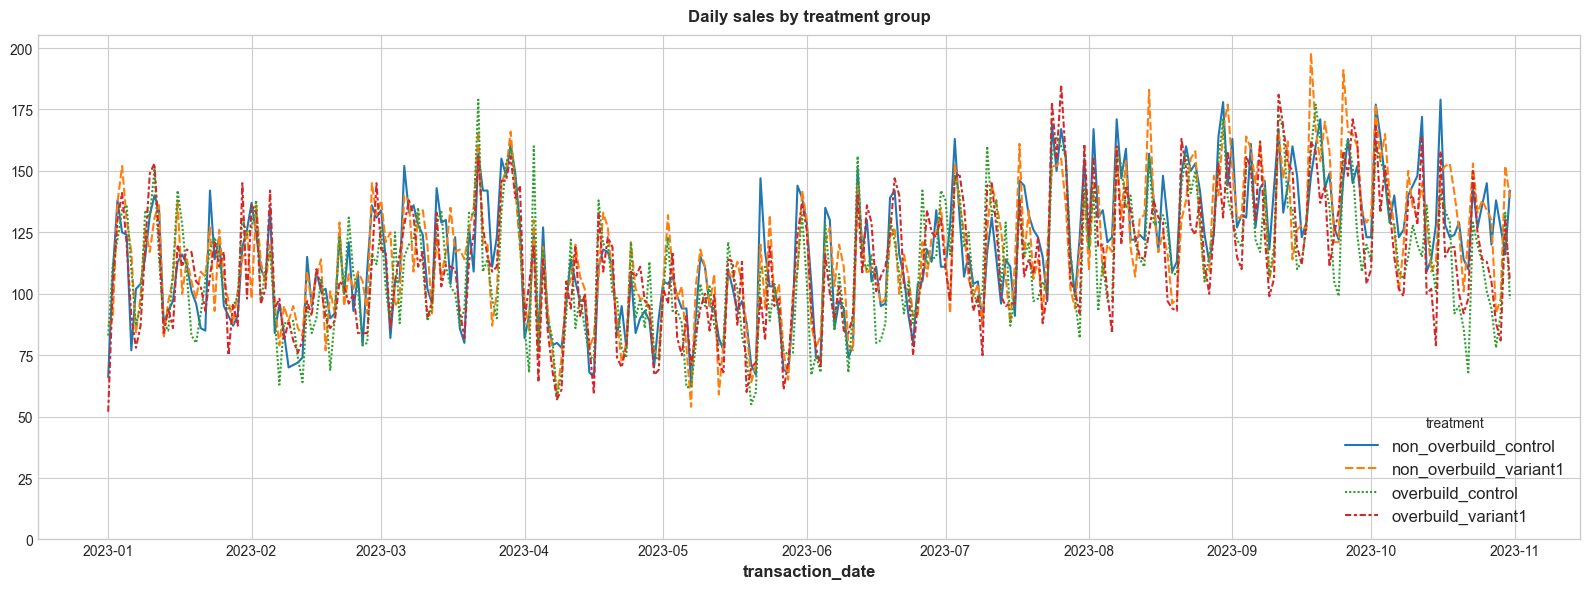

In [139]:
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(16,6),
    titlesize=12,
    titleweight="bold",
)

plt.rc(
    "axes",
    labelweight="bold",
    labelsize=12,
    titleweight="bold",
    titlesize=12,
    titlepad=10,
)

plt.rc(
    "legend",
    fontsize=12
)

plot_params = dict(
    color="0.75",
    style="._",
    markeredgecolor="0.25",
    marketfacecolor="0.25",
    legend=True
)

sns.lineplot(data=daily_sales_by_treatment)
plt.ylim(0)
plt.title('Daily sales by treatment group')

### Same evaluations at region level

In [140]:
# seems easiest to have a separate lookup
postcode_to_region_query = """

SELECT 
  postcode, 
  town, 
  local_authority,
  region
FROM `prj-vo-aa-p-cdh-prod.geography.geography_postcode` 

"""

postcode_to_region = bq_client.query(postcode_to_region_query).to_dataframe()
postcode_to_region.shape

(2632804, 4)

In [141]:
daily_sales_by_region = (postcode_pricing_list[['postcode', 'treatment']]
                            .set_index('postcode')
                            .join(daily_sales_by_postcode)
                            .join(postcode_to_region[['postcode', 'region']].set_index('postcode'))
                            .reset_index()
                            .groupby(['transaction_date', 'treatment', 'region'])
                            .sum()
                            .reset_index()
                            #.pivot(index='transaction_date', columns=['region', 'treatment'], values='num_sales')
                            )

/var/folders/pq/1pygt1_j2fn4w2qq_zh70bdh0000gp/T/ipykernel_66582/1381752512.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  daily_sales_by_region = (postcode_pricing_list[['postcode', 'treatment']]


In [142]:
daily_sales_by_region

transaction_date              treatment                       region  \
0          2023-01-01  non_overbuild_control               Greater London   
1          2023-01-01  non_overbuild_control     Home Counties and Anglia   
2          2023-01-01  non_overbuild_control                   North West   
3          2023-01-01  non_overbuild_control      Scotland and North East   
4          2023-01-01  non_overbuild_control                  South Coast   
...               ...                    ...                          ...   
9715       2023-10-31     overbuild_variant1      Scotland and North East   
9716       2023-10-31     overbuild_variant1                  South Coast   
9717       2023-10-31     overbuild_variant1         South West and Wales   
9718       2023-10-31     overbuild_variant1                West Midlands   
9719       2023-10-31     overbuild_variant1  Yorkshire and East Midlands   

      num_sales  
0          14.0  
1           5.0  
2          10.0  
3          12.0  
4           2.0  
...         ...  
9715       14.0  
9716        4.0  
9717        7.0  
9718       16.0  
9719       19.0  

[9720 rows x 4 columns]

/var/folders/pq/1pygt1_j2fn4w2qq_zh70bdh0000gp/T/ipykernel_66582/2842789025.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


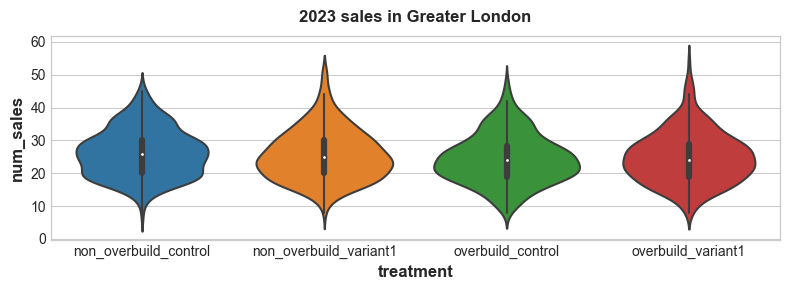

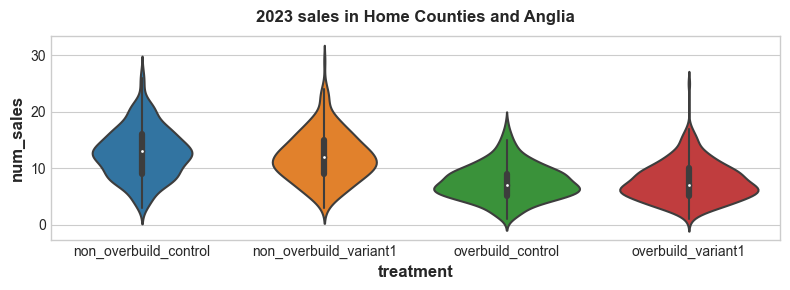

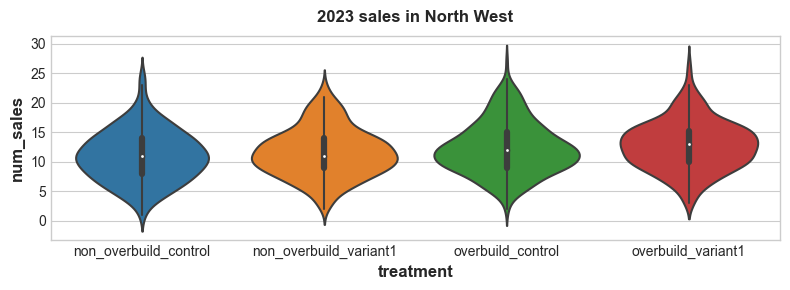

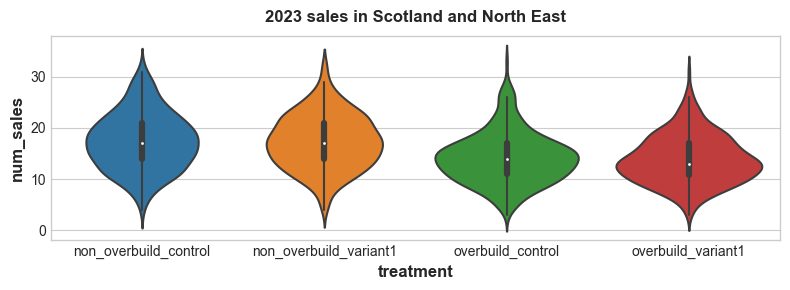

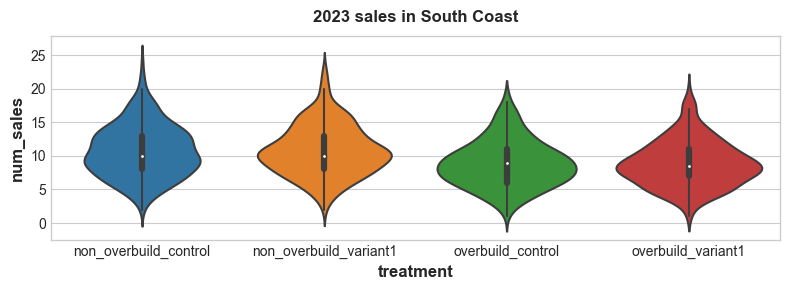

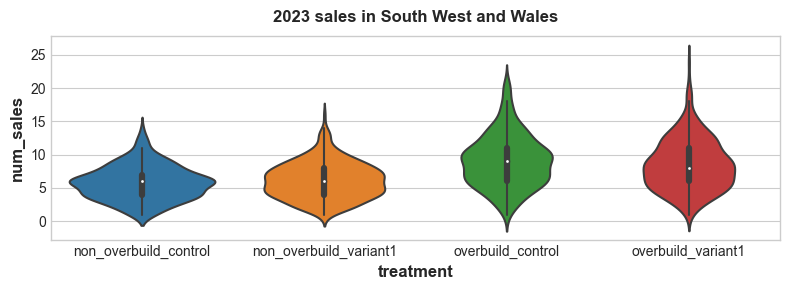

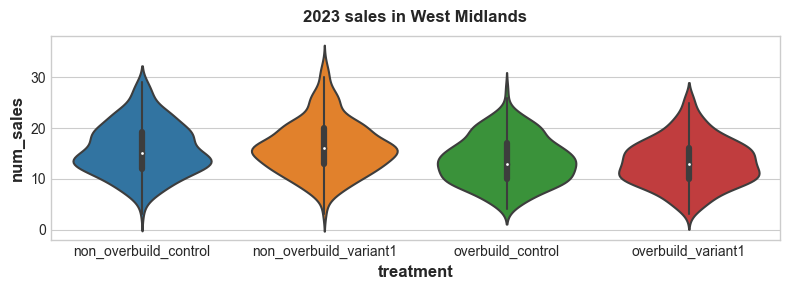

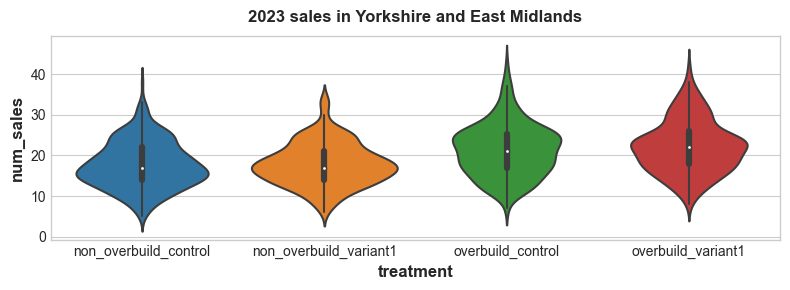

In [143]:
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(8,3),
    titlesize=12,
    titleweight="bold",
)

for region in daily_sales_by_region.region.unique():
    sns.violinplot(x="treatment", y="num_sales", data=daily_sales_by_region.query("region == @region"))
    plt.title(f'2023 sales in {region}')
    plt.show()


In [144]:
# for region in {region for region,_ in daily_sales_by_region.columns}:
#     sns.lineplot(data=daily_sales_by_region[region].loc['2023-07-01':]) # limit to legible range?
#     plt.ylim(0)
#     plt.title(f'Daily sales by treatment group: {region}')
#     plt.show()


## Write the Group allocations to BQ

In [145]:
# Since string columns use the "object" dtype, pass in a (partial) schema
# to ensure the correct BigQuery data type.
job_config = bigquery.LoadJobConfig(schema=[
    bigquery.SchemaField("postcode", "STRING"),
    bigquery.SchemaField("treatment", "STRING")
], write_disposition="WRITE_TRUNCATE")  


postcode_treatment_table_id = f"{dataset}.{postcode_treatment_table}"

job = bq_client.load_table_from_dataframe(
    postcode_pricing_list, postcode_treatment_table_id, job_config=job_config
)

# Wait for the load job to complete.
job.result()

print(f"writing to {bq_client.project}.{postcode_treatment_table_id}")

writing to prj-vo-aa-p-data-science-exp.m7914180.rnba-1252-postcode-pricing-group-allocations


### Order mix checks

Uses the table containing the group allocation, so do this after writing to BQ

In [146]:
# query from https://vm-uk-dp.slack.com/archives/C050RFWUHNG/p1683127266414889, 
# swapping in new table name and changing month to April 2023

order_mix_query_template = """

WITH
PPGA AS (
  SELECT
    pdb.icoms_id.icoms_premises_uid AS premises_uid,
    IFNULL(ppga.postcode,pdb.premises_location.postcode) AS postcode,
    ppga.treatment AS treatment
  FROM
    `prj-vo-aa-p-data-modellin-prod.data_modelling_base.premises_details_base` pdb
  LEFT JOIN
    `{postcode_selection_table}` ppga 
  ON
    ppga.postcode = pdb.premises_location.postcode 
),
UA as (

SELECT DISTINCT
  _table_suffix AS date,
  hits.transaction.transactionId,
  CAST((select value from unnest(hits.customDimensions) where index = 41) AS INT64) as premise_uid,
  (select value from unnest(hits.customDimensions) where index = 42) as premise_postcode,
  product.v2ProductName as product_name, 
  product.productPrice/1000000 as monthly_cost,
  PPGA.treatment

FROM
  `prj-vm-p-ga360-landing.vmdata_ga360_landing.ga_sessions_*`,
  UNNEST(hits) hits

LEFT JOIN unnest(hits.product) product
INNER  JOIN PPGA
  ON CAST((select value from unnest(hits.customDimensions) where index = 41) AS INT64) = PPGA.premises_uid
  
WHERE 
  _table_suffix between '20231001' AND '20231231'
  AND hits.transaction.transactionId is not null
  AND starts_with(hits.page.pagePath,'/join/')

)

SELECT * 
FROM UA

"""

# consider a relevant date range for this check
full_postcode_treatment_table_name = f"{bq_client.project}.{dataset}.{postcode_treatment_table}"

order_mix_query = (order_mix_query_template
                   .format(
                      postcode_selection_table=full_postcode_treatment_table_name
                  ))

order_mix = bq_client.query(order_mix_query).to_dataframe()

order_mix.shape


(46315, 7)

In [147]:
order_mix.groupby('treatment').monthly_cost.agg(['min', 'mean', 'median', 'max'])

min       mean  median    max
treatment                                             
non_overbuild_control   25.5  34.612915   31.99  115.0
non_overbuild_variant1  25.5  34.299599   31.99  103.0
overbuild_control       25.5  33.948532   31.99  107.0
overbuild_variant1      25.5  34.378538   31.99  121.0

# 2 - Upload the bundle prices

Pasted from Jira into CSV, then uploaded

In [148]:
# TODO need a file file bundle prices


# PLACEHOLDER with nonsensical data
bundles = pd.read_excel('../data/bundle_prices/PLACEHOLDER-rnba-1252-bundle-prices.xlsx', dtype={'delta_price_duration': 'Int64'})
bundles

bundle_id  delta_price_duration  delta_price               treatment  \
0       1111                    99         -444   non_overbuild_control   
1       2222                    99         -444  non_overbuild_variant1   
2       3333                    99         -444       overbuild_control   
3       4444                    99         -444      overbuild_variant1   

   expected_price  price  
0             111    555  
1             222    666  
2             333    777  
3             444    888

In [149]:
# upload to bundle_price_table
job_config = bigquery.LoadJobConfig(schema=[
    bigquery.SchemaField("bundle_id", "INTEGER"),
    bigquery.SchemaField("delta_price_duration", "float"),
    bigquery.SchemaField("treatment", "STRING"),
    bigquery.SchemaField("expected_price", "float"),
    bigquery.SchemaField("price", "float"),
    bigquery.SchemaField("delta_price", "INTEGER"),
], write_disposition="WRITE_TRUNCATE") 

bundle_price_table_id = f"{dataset}.{bundle_price_table}"

job = bq_client.load_table_from_dataframe(
    bundles, bundle_price_table_id, job_config=job_config
)

print(f"Updated XGN PON postcodes in {bq_client.project}.{bundle_price_table_id}")

Updated XGN PON postcodes in prj-vo-aa-p-data-science-exp.m7914180.rnba-1252-bundle-prices


# 3 - Aggregated files for Compax

# Create the data files for Compax

https://virginmediao2.atlassian.net/browse/CS-2630

Thread with more details about the format they want:
https://vm-uk-challenger.slack.com/archives/C04661DMH3Q/p1685975687063779


**New Jira:**

https://virginmediao2.atlassian.net/browse/CS-2646

('control' rows in the bundle_price file should not have any pricing information)


```
notes from Tomislav: date should be in format
2023-06-13, 2023-07-20
not
13-06-2023, 20-07-2023
So year then month then day.

And order of columns should be
treatment,bundle_id,price,expected_price,delta_price,delta_price_duration
control1,4015,65,31.99,7,18
not
bundle_id,price,expected_price,delta_price,treatment,delta_price_duration
4015,65,31.99,7,control1,18
Treatment first


### File 1 - Postcodes and Treatments

Take an existing set of group allocations.

Refresh this when overbuild flags change.

In [150]:
postcode_treatments_query_template = """

SELECT
    postcode,
    treatment,
    overbuild,

FROM `{postcodes_table}`

ORDER BY postcode ASC, treatment ASC, overbuild ASC

"""

full_postcode_treatment_table_name = f"{bq_client.project}.{dataset}.{postcode_treatment_table}"
postcode_treatments_query = postcode_treatments_query_template.format(postcodes_table=full_postcode_treatment_table_name)

postcode_treatments = bq_client.query(postcode_treatments_query).to_dataframe()
postcode_treatments.shape

(261047, 3)

In [151]:
def write_postcode_treatments_to_file(postcode_treatments, filepath:str):

    postcode_treatment_cols = ['postcode', 'treatment']
    postcode_treatment_file_contents = postcode_treatments[postcode_treatment_cols].drop_duplicates().sort_values(['postcode', 'treatment'])

    postcode_treatment_file_contents.to_csv(filepath, index=False)
    print(f"postcode_treaments in {filepath} - REMEMBER TO ADD START AND END DATES")

In [152]:
postcode_treatments_filename =  f"postcode_treatments_{jira_code}"
postcode_treatments_filepath = f"../output/{postcode_treatments_filename}.txt"

write_postcode_treatments_to_file(postcode_treatments, postcode_treatments_filepath)

postcode_treaments in ../output/postcode_treatments_rnba-1252.txt - REMEMBER TO ADD START AND END DATES


### File 2 - Bundles and Prices

In [153]:
bundle_prices_query_template = """

    SELECT
        bundle_id,
        price,
        expected_price,
        delta_price,
        treatment,
        delta_price_duration
        
    FROM `{bundle_table}`

    ORDER BY bundle_id ASC, treatment ASC

"""

full_bundle_price_table_name = f"{bq_client.project}.{dataset}.{bundle_price_table}"
bundle_prices_query = bundle_prices_query_template.format(bundle_table=full_bundle_price_table_name)

bundle_prices = bq_client.query(bundle_prices_query).to_dataframe(dtypes={'delta_price_duration':'Int64'})

In [154]:
# # make sure nothing has gone wrong with day / month ordering
# formatted_start_date = bundle_prices.Start_date[0].strftime('%Y-%m-%d')
# formatted_end_date =  bundle_prices.End_date[0].strftime('%Y-%m-%d')

# formatted_start_date, formatted_end_date

In [155]:
def write_bundle_prices_to_file(bundle_prices, filepath:str):

    bundle_price_cols = ['treatment', 'bundle_id','price','expected_price','delta_price','delta_price_duration']

    bundle_price_file_contents = bundle_prices[bundle_price_cols].drop_duplicates().sort_values(['bundle_id', 'treatment'])

    bundle_price_file_contents.to_csv(filepath, index=False)
    print(f"bundle_prices in {filepath} - REMEMBER TO ADD START AND END DATES")


In [156]:
bundle_price_filename =  f"bundle_prices_{jira_code}"
bundle_price_filepath = f"../output/{bundle_price_filename}.txt"

write_bundle_prices_to_file(bundle_prices, bundle_price_filepath)

bundle_prices in ../output/bundle_prices_rnba-1252.txt - REMEMBER TO ADD START AND END DATES


# --> MANUALLY ADD START AND END DATES

 - in the file, as a header
 - in the file names

# Offline testing file

This is just a list of postcodes, with no other details.

In [ ]:
offline_testing_file_query_template = """

    SELECT DISTINCT postcode, treatment
    FROM `{postcode_treatment_table_id}`
    ORDER BY postcode

"""
postcode_treatment_table_id = f"{bq_client.project}.{dataset}.{postcode_treatment_table}"

offline_testing_file_query = offline_testing_file_query_template.format(postcode_treatment_table_id=postcode_treatment_table_id)

offline_testing_file_data = bq_client.query(offline_testing_file_query).to_dataframe()


In [ ]:
offline_testing_file_data.to_csv(f"../output/{jira_code}_offline_testing_file_20230914_to_20231026.csv", index=False)

# Int5 testing

https://virginmediao2.atlassian.net/browse/CS-2680

In [ ]:
# get the existing postcode treatments and modify
postcode_treatments_query_template = """

SELECT
    postcode,
    treatment,
    overbuild,

FROM `{postcodes_table}`

ORDER BY postcode ASC, treatment ASC, overbuild ASC

"""

full_postcode_treatment_table_name = f"{bq_client.project}.{dataset}.{postcode_treatment_table}"
postcode_treatments_query = postcode_treatments_query_template.format(postcodes_table=full_postcode_treatment_table_name)

postcode_treatments = bq_client.query(postcode_treatments_query).to_dataframe()

# replace with test values -- these postcodes were used in testing before; I don't know whether they are suitable for Int5 or not (or what Int5 is...)
test_postcode_treatments = postcode_treatments.groupby('treatment').head(1).reset_index(drop=True)
test_postcode_treatments.loc[test_postcode_treatments.treatment == 'variant4', 'postcode'] = "PR25 2XD"
test_postcode_treatments.loc[test_postcode_treatments.treatment == 'control4', 'postcode'] = "PR26 7SE"

# write to file
test_postcode_treatments_filename =  f"TEST_postcode_treatments_{jira_code}"
test_postcode_treatments_filepath = f"../output/{test_postcode_treatments_filename}.csv"
write_postcode_treatments_to_file(test_postcode_treatments, test_postcode_treatments_filepath)

In [ ]:
#[bundle prices are the same]




In [ ]:
bundle_price_filename =  f"bundle_prices_{jira_code}"
bundle_price_filepath = f"../output/{bundle_price_filename}.csv"

In [ ]:
# group_allocations_query_template = """

#     SELECT DISTINCT postcode, treatment
#     FROM `{postcode_treatment_table_id}`
#     ORDER BY postcode

# """

# postcode_treatment_table_id = f"{bq_client.project}.{dataset}.{postcode_treatment_table}"
# group_allocations_query = group_allocations_query_template.format(postcode_treatment_table_id=postcode_treatment_table_id)

# group_allocations = bq_client.query(group_allocations_query).to_dataframe()

In [ ]:
test_postcodes_query_template = """

SELECT DISTINCT
  post_code as postcode,
  ICOMS_SITE_ID,

FROM `prj-vm-p-data-cdh-01.vmdata_customer_data_hub.stg1_badger_hub_site_premise`
WHERE UPPER(TRIM(REGEXP_REPLACE(post_code, ' ', ''))) in (SELECT UPPER(TRIM(REGEXP_REPLACE(postcode, ' ', ''))) FROM `{postcode_treatment_table_id}`)
AND ICOMS_SITE_ID = '01'
ORDER BY post_code


"""

postcode_treatment_table_id = f"{bq_client.project}.{dataset}.{postcode_treatment_table}"
test_postcodes_query = test_postcodes_query_template.format(postcode_treatment_table_id=postcode_treatment_table_id)

test_postcodes = bq_client.query(test_postcodes_query).to_dataframe()

In [ ]:
test_postcodes

In [ ]:
test_postcodes[test_postcodes.postcode.str.match('PR2')]

In [ ]:
# https://vm-uk-challenger.slack.com/archives/D04U9GR8LCA/p1678975771086639


# Another test file

Say 100 in each group and 100 more out of scope

https://teams.microsoft.com/l/message/19:4c35153964d748baaa241c6ae468898c@thread.v2/1695394644899?context=%7B%22contextType%22%3A%22chat%22%7D

In [ ]:
new_test_postcodes_query = """

WITH 
controls AS (
  SELECT postcode, treatment, ROW_NUMBER() OVER() AS row_number
  FROM `prj-vo-aa-p-data-science-exp.m7914180.cs-2670-postcode-pricing-group-allocations`
  WHERE treatment = 'control4'
),
variants AS (
  SELECT postcode, treatment, ROW_NUMBER() OVER() AS row_number
  FROM `prj-vo-aa-p-data-science-exp.m7914180.cs-2670-postcode-pricing-group-allocations`
  WHERE treatment = 'variant4'
),
out_of_scope AS (

    SELECT
        UPPER(TRIM(postcode)) AS postcode, 
        'out_of_scope' AS treatment,
        ROW_NUMBER() OVER() AS row_number,
        
    FROM `prj-vo-aa-p-cdh-prod.data_enablement_models.staging_overbuild_alternative_network_by_postcode`
    WHERE vm_postcode = 1
    AND households >= 10
    AND cable_postcode = 'Y' 

    AND postcode NOT IN (SELECT postcode FROM controls)
    AND postcode NOT IN (SELECT postcode FROM variants)

)
SELECT postcode, treatment, FROM controls WHERE row_number <= 100
UNION ALL
SELECT postcode, treatment, FROM variants WHERE row_number <= 100
UNION ALL
SELECT postcode, treatment, FROM out_of_scope WHERE row_number <= 100


"""

new_test_postcodes = bq_client.query(new_test_postcodes_query).to_dataframe()
new_test_postcodes.shape

In [ ]:
new_test_postcodes.sample(10)

In [ ]:
# check no overlaps
#pd.crosstab(new_test_postcodes.postcode, new_test_postcodes.treatment).to_clipboard()

In [ ]:
new_test_postcodes.to_csv('../output/CS-2670-sample_postcodes_control_variant_out_of_scope.csv', index=False)